In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

from readers import reader, trigger_reader
from processing import data_processor
from visualization import visualizer
from config import RECORDING_FILE

In [ ]:
NPreader = reader.NeuropixelsReader(RECORDING_FILE)
channels = [0, 1, 2]  # Example channels
start_times = [6569000]  # Start times in ms
# window=3600000 # in ms
window = 6*10*1000
conv_to_uv=False
data = NPreader.read_data(channels, start_times, window, convert_to_uv=conv_to_uv, get_all_channels=False)

# data_one_channel = data[6569000][0]
# np.save('../data/data_array_60min.npy', data_one_channel)
data_one_channel = np.load('../data/temp_array_10min_middle.npy')

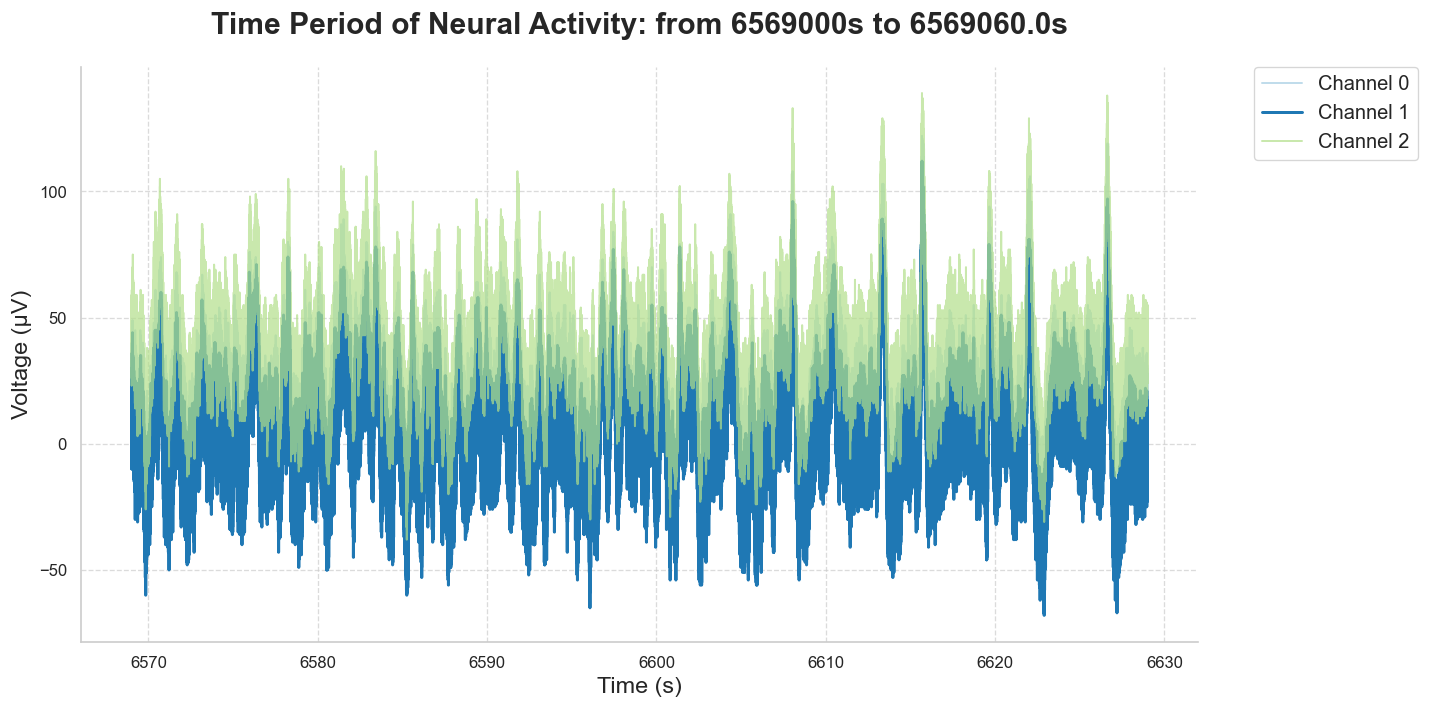

In [5]:
viz = visualizer.NeuralDataVisualizer(style='whitegrid', context='paper', color_scheme = "Paired")

custom_config = visualizer.PlotConfig(
        figsize=(12, 6),
        dpi=120,
        title_fontsize=18,
        label_fontsize=14,
        legend_position='right'
    )

for time_period_name, time_period_data in data.items():
    fig, ax = viz.plot_channels(
        data=time_period_data,
        time_period_name=time_period_name,
        window = window/1000,
        config = custom_config,
        conv_to_uv=True,
        highlight_channels = [1]
    )

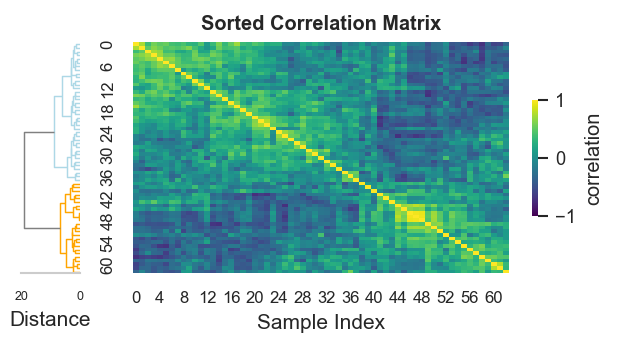

In [ ]:
DP = data_processor.NeuropixelsDataProcessor(sampling_rate = NPreader.sampling_rate)

resample_data = DP.preprocess_signal(data_one_channel, DP.batch_size, DP.overlap)
freq, PSD = DP.compute_power_spectrum(resample_data, DP.bin_size)
normalized_PSD = DP.normalize_power_spectrum(PSD)

nPSD_low = normalized_PSD[:,:30]

correlation_matrix = np.corrcoef(nPSD_low)
linkage_matrix, cluster_labels, clusters = DP.cluster_correlation_matrix(correlation_matrix, num_clusters=20)

fig, ax0, ax1 = viz.plot_sorted_correlation_matrix(correlation_matrix, linkage_matrix)

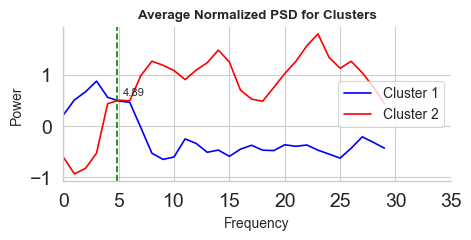

In [10]:
from collections import OrderedDict
avg_psd_cluster = []
clusters = OrderedDict(sorted(clusters.items(), reverse=True, key = lambda x : len(x[1])))
for indexes in clusters.values():
    avg_psd_cluster.append(np.mean(nPSD_low[indexes], axis=0))

transition_frequencies = DP.calculate_transition_frequency(freq[:30], avg_psd_cluster[0], avg_psd_cluster[1])

fig = viz.plot_transition_frequency(freq[:30], avg_psd_cluster[0], avg_psd_cluster[1], transition_frequencies)

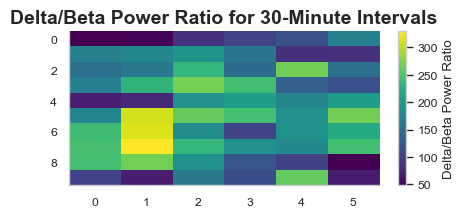

In [11]:
delta_beta_ratio = DP.calculate_delta_beta_ratio(PSD)
fig = viz.plot_delta_beta_matrix(delta_beta_ratio, num_bins_x = 6)

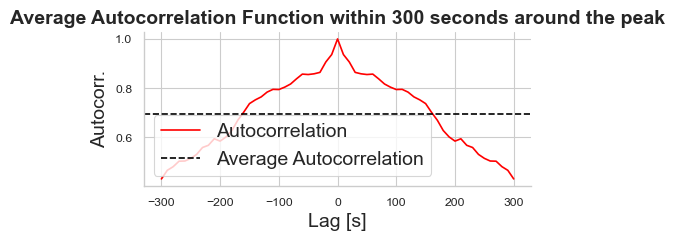

In [12]:
autocorr, norm_autocorr, avg_peak_index = DP.calculate_autocorrelation(delta_beta_ratio)
fig = viz.plot_autocorr(norm_autocorr, avg_peak_index, peak_range = 300, bin_second = DP.bin_second)

In [13]:
dict_sleep_cycles = DP.analyze_sleep_cycles(norm_autocorr)

print("Sleep Cycle duration analysis")
for key, value in dict_sleep_cycles.items():
    if key=='kde':
        continue
    print("{0}: {1}".format(key,value))

Sleep Cycle duration analysis
average distance between cycles: 70.0
standard deviation: 21.60246899469287
95 percent confidence interval: (52.71474239421258, 87.28525760578742)
maximal cycle time (sec): 100
minimal cycle time (sec): 50


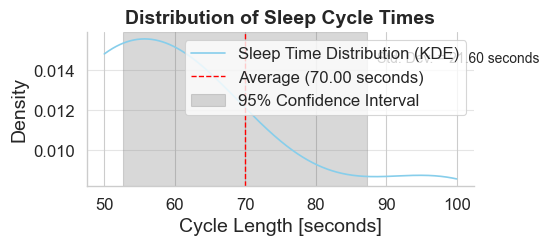

In [14]:
x_values, y_values = dict_sleep_cycles['kde']
avg_dist_p2p = dict_sleep_cycles['average distance between cycles']
lower_bound, upper_bound = dict_sleep_cycles['95 percent confidence interval']
std_dev = dict_sleep_cycles['standard deviation']

viz.plot_kde_distribution(x_values, y_values, avg_dist_p2p, lower_bound, upper_bound, std_dev)

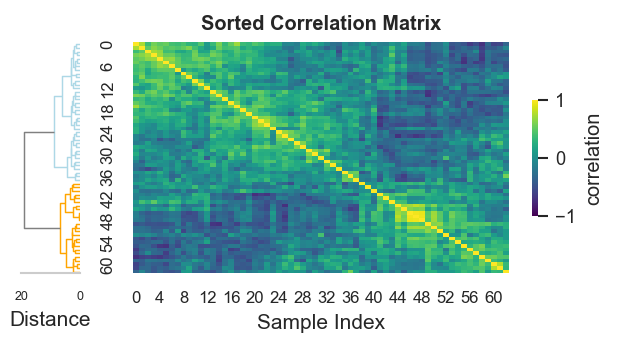

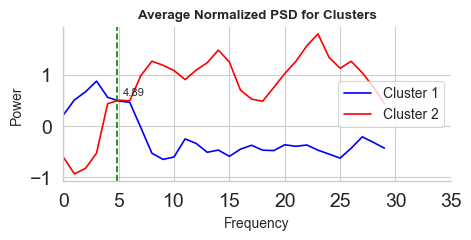

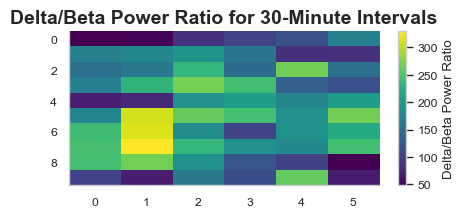

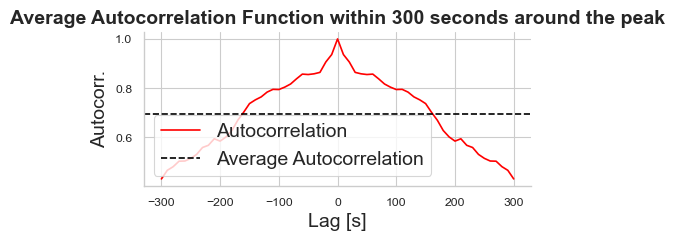

Sleep Cycle duration analysis
average distance between cycles: 70.0
standard deviation: 21.60246899469287
95 percent confidence interval: (52.71474239421258, 87.28525760578742)
maximal cycle time (sec): 100
minimal cycle time (sec): 50


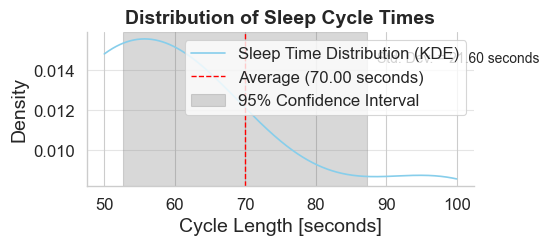

In [16]:
DP = data_processor.NeuropixelsDataProcessor(sampling_rate = NPreader.sampling_rate)
DP.pipeline(data_one_channel)